In [1]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import cv2 as cv # pip install opencv-python
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

Using TensorFlow backend.


Total number of categories: 150
Total number of images in dataset: 10842


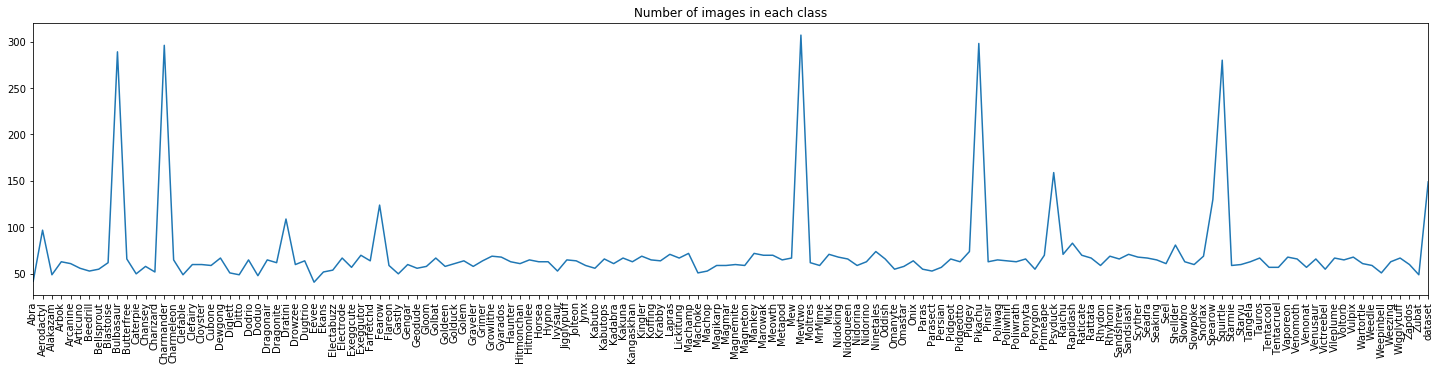

In [2]:
# A little bit of data exploration
path = './dataset' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [3]:
# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [4]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

./dataset/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


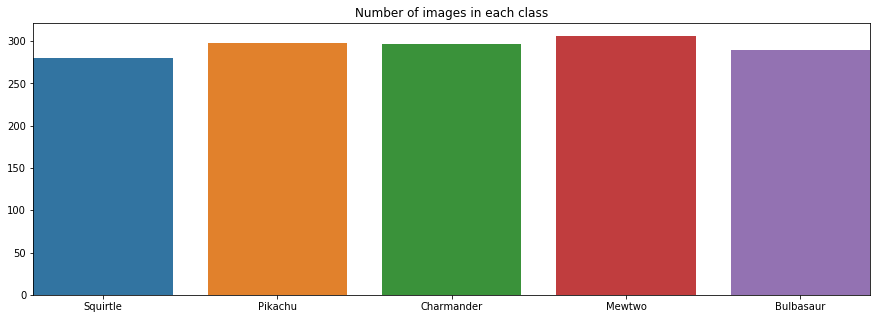

In [5]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [6]:
# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

In [7]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
# img = X[600]
# img = img.reshape([-1, 96, 96, 3])

# i = 0
# fig = plt.figure(figsize = (18, 8))

# for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
#     fig.add_subplot(2, 5, i+1)
#     plt.imshow(np.squeeze(flow[:, :, ::-1]))
#     plt.axis('off')
#     i += 1
#     if i >= 10:
#         break

In [16]:
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(imbalanced), activation = 'softmax'))

model.summary()

#checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
checkpoint = ModelCheckpoint('/Users/nakayama/Desktop/lesson/advanced/work/pokemon/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 100, validation_data = [X_test, y_test],
#                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 10, validation_data = [X_test, y_test],
                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 64)        36928     
__________

Text(0.5, 1.0, 'loss')

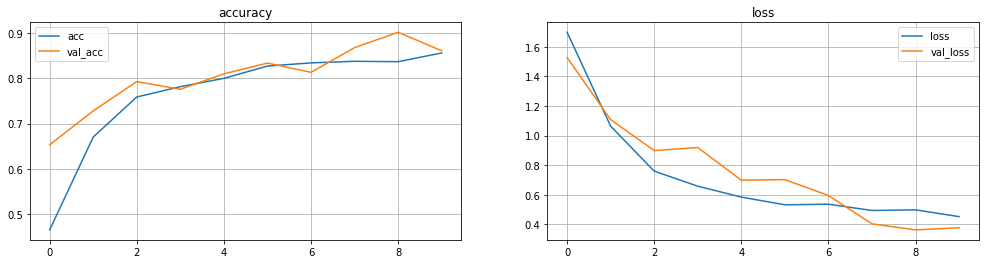

In [17]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
#plt.plot(history.history['accuracy'], label = 'acc')
#plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [18]:
# Loading weights from best model
#model.load_weights('../working/best_model.hdf5')
model.load_weights('/Users/nakayama/Desktop/lesson/advanced/work/pokemon/best_model.hdf5')

# Saving all model
#model.save('../working/model.hdf5')
model.save('/Users/nakayama/Desktop/lesson/advanced/work/pokemon/model.hdf5')

OSError: Unable to open file (unable to open file: name = '/Users/nakayama/Desktop/lesson/advanced/work/pokemon/best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/6087/2437349-pikachu.png',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

In [20]:
# Lists to store our future data
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:        
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv.imdecode(image, cv.IMREAD_COLOR)
        val_x.append(image)
        val_y.append(i)

# plt.imshow(image[:, :, ::-1])

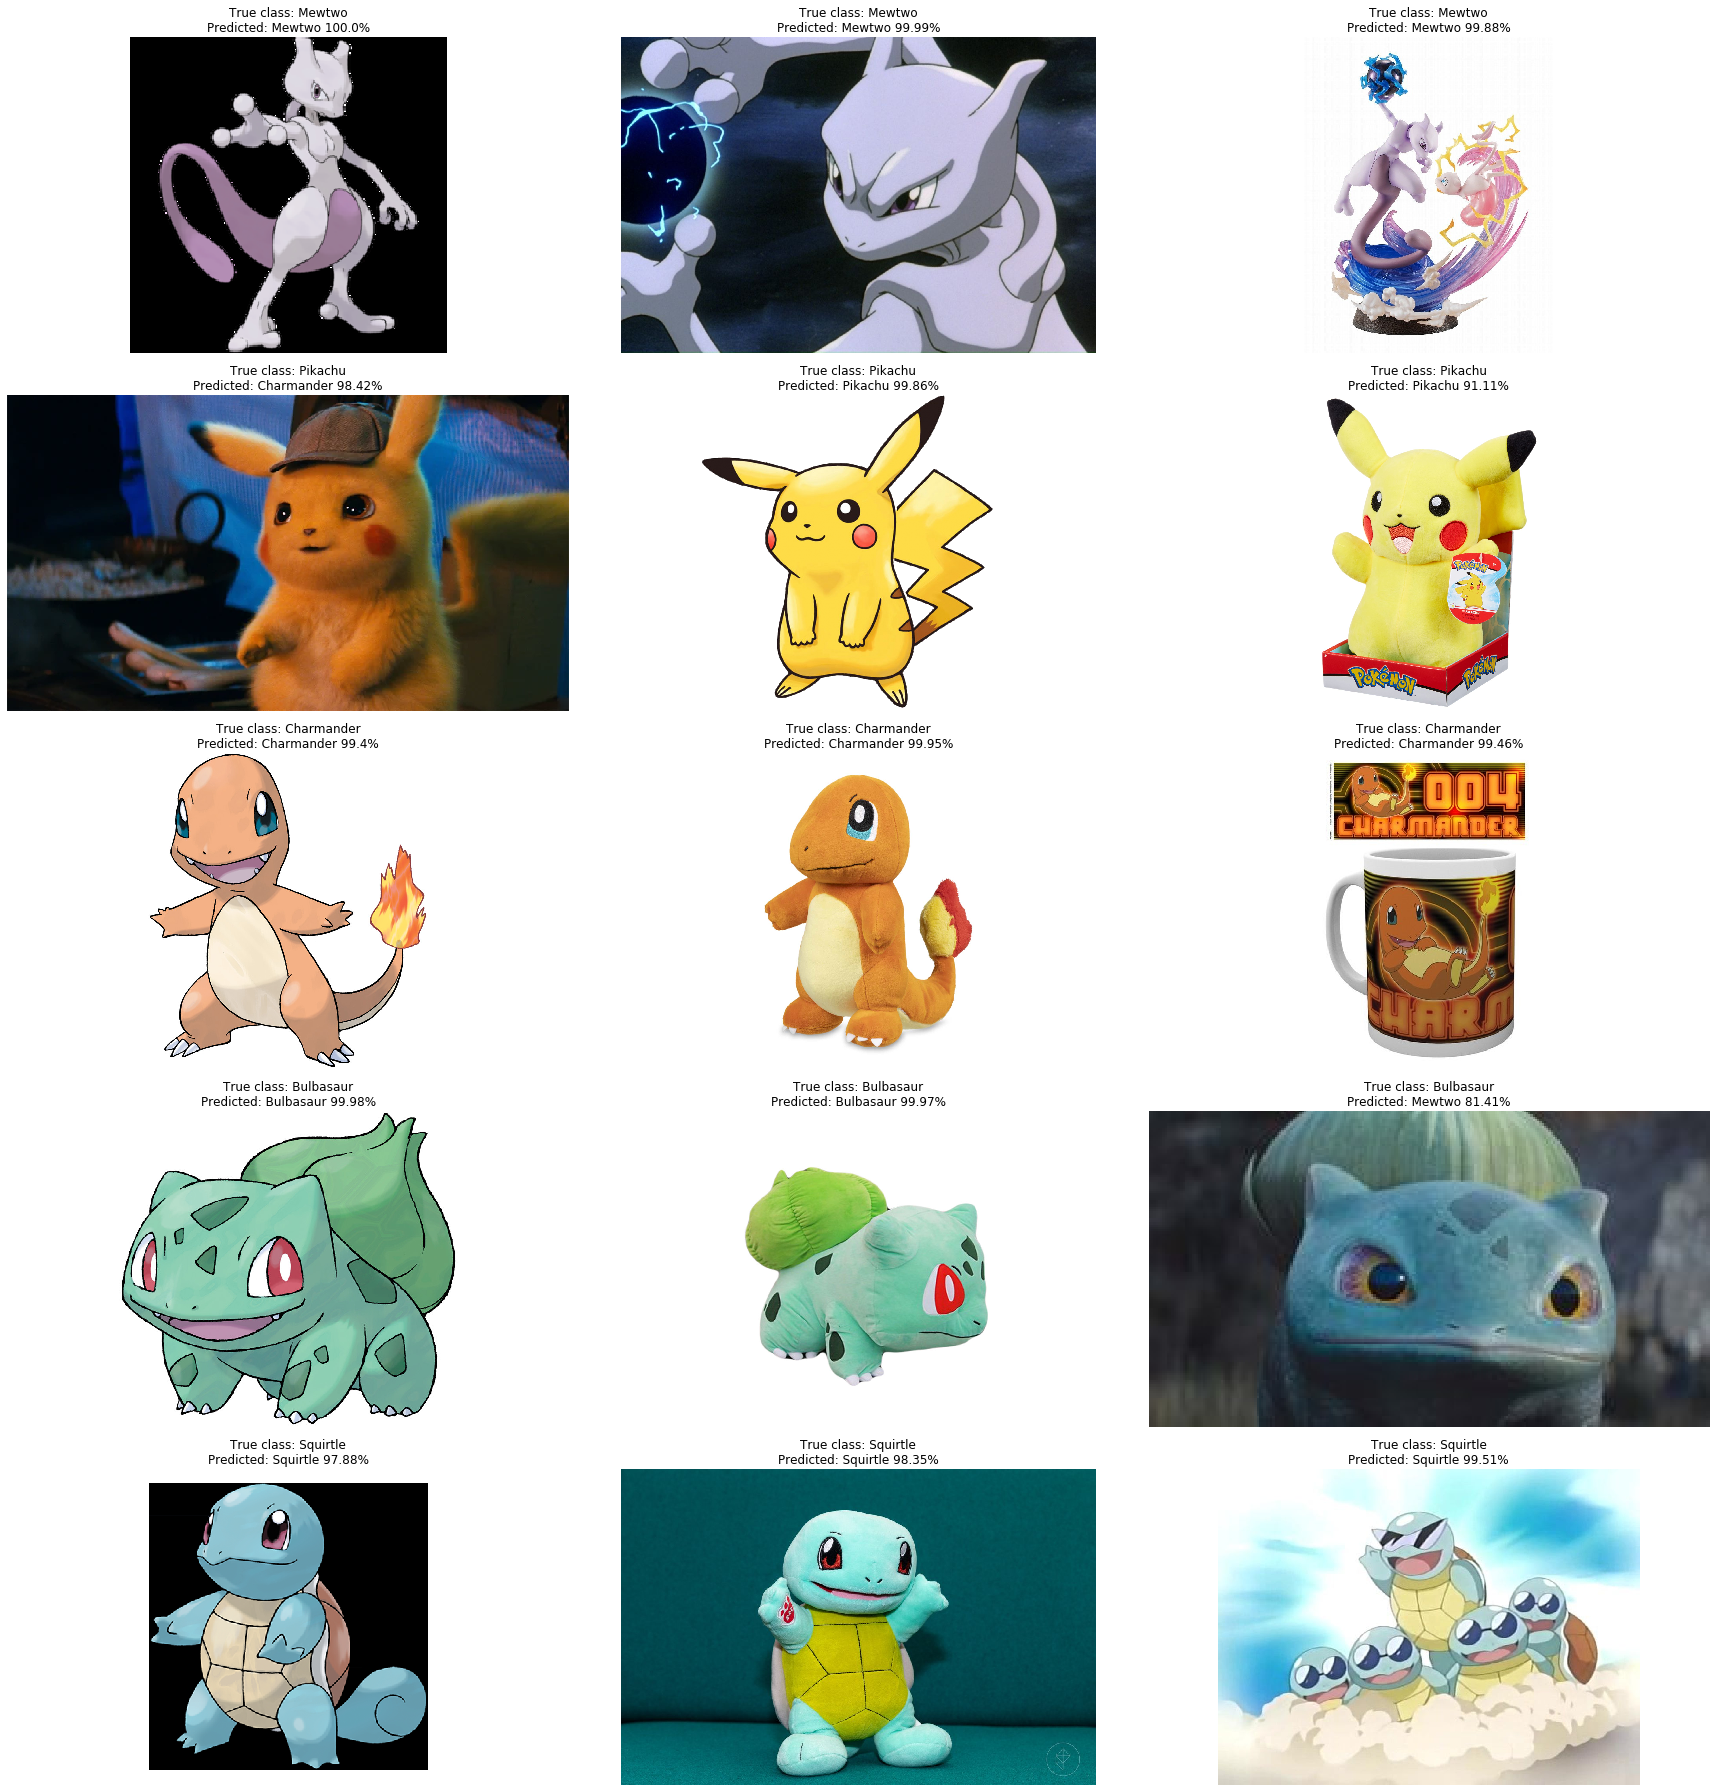

In [21]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 25))

for i, j in enumerate(zip(val_x, val_y)): # i - for subplots
    orig = j[0] # Original, not resized image
    label = j[1] # Label for that image
    
    image = cv.resize(orig, (96, 96)) # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0 # Reshape and scale resized image
    preds = model.predict(image) # Predicting image
    pred_class = np.argmax(preds) # Defining predicted class
    
    true_label = f'True class: {imbalanced[label]}'
    pred_label = f'Predicted: {imbalanced[pred_class]} {round(preds[0][pred_class] * 100, 2)}%'
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}')
    plt.axis('off')
    
plt.tight_layout()